# 1. Linformer style Attention

In [ ]:
from math import pi, log
from functools import wraps

import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat

# helpers

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cache_fn(f):
    cache = None
    @wraps(f)
    def cached_fn(*args, _cache = True, **kwargs):
        if not _cache:
            return f(*args, **kwargs)
        nonlocal cache
        if cache is not None:
            return cache
        cache = f(*args, **kwargs)
        return cache
    return cached_fn

# structured dropout, more effective than traditional attention dropouts

def dropout_seq(seq, mask, dropout):
    b, n, *_, device = *seq.shape, seq.device
    logits = torch.randn(b, n, device = device)

    if exists(mask):
        logits = logits.masked_fill(~mask, -torch.finfo(logits.dtype).max)

    keep_prob = 1. - dropout
    num_keep = max(1,  int(keep_prob * n))
    keep_indices = logits.topk(num_keep, dim = 1).indices

    batch_indices = torch.arange(b, device = device)
    batch_indices = rearrange(batch_indices, 'b -> b 1')

    seq = seq[batch_indices, keep_indices]

    if exists(mask):
        seq_counts = mask.sum(dim = -1)
        seq_keep_counts = torch.ceil(seq_counts * keep_prob).int()
        keep_mask = torch.arange(num_keep, device = device) < rearrange(seq_keep_counts, 'b -> b 1')

        mask = mask[batch_indices, keep_indices] & keep_mask

    return seq, mask

# helper classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn, context_dim = None):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)
        self.norm_context = nn.LayerNorm(context_dim) if exists(context_dim) else None

    def forward(self, x, **kwargs):
        x = self.norm(x)

        if exists(self.norm_context):
            context = kwargs['context']
            normed_context = self.norm_context(context)
            kwargs.update(context = normed_context)

        return self.fn(x, **kwargs)

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim = -1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)

class LinformerAttention(nn.Module):
    def __init__(self, dim, seq_len, k=128, heads=8, dim_head=64, dropout=0.1):
        super().__init__()
        assert dim % heads == 0, "dim must be divisible by number of heads"

        self.seq_len = seq_len
        self.k = k
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5

        inner_dim = dim_head * heads
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)

        self.proj_k = nn.Parameter(torch.randn(seq_len, k))
        self.proj_v = nn.Parameter(torch.randn(seq_len, k))

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x, context=None):
        b, n, d, h, k = x.shape[0], self.seq_len, self.dim_head, self.heads, self.k
        context = x if context is None else context

        q = self.to_q(x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        # Projection to k
        k = torch.einsum('bnd,nk->bkd', k, self.proj_k)
        v = torch.einsum('bnd,nk->bkd', v, self.proj_v)
        k, v = self.dropout(k), self.dropout(v)  # Dropout을 후처리로 이동
        # 압축된 후 Dropout을 적용해 정보 손실 없이 Requlation 효과 유지

        # Reshape for multi-head attention
        q = rearrange(q, 'b n (h d) -> b h n d', h=h)
        k = rearrange(k, 'b k (h d) -> b h k d', h=h)
        v = rearrange(v, 'b k (h d) -> b h k d', h=h)

        # Compute scaled dot-product attention
        attn = (q @ k.transpose(-1, -2)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn + 1e-6) # 작은 값 추가해 안정화 # 숫자 0으로 사라지는 현상 방지

        out = attn @ v
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


# main class

class PerceiverIO(nn.Module):
    def __init__(self, depth, dim, queries_dim, logits_dim, num_latents=64, latent_dim=512,
                 cross_heads=1, latent_heads=8, cross_dim_head=64, latent_dim_head=64, seq_len=784, k=128, decoder_ff=False):
        super().__init__()
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))

        self.cross_attn = LinformerAttention(latent_dim, seq_len, k, heads=cross_heads, dim_head=cross_dim_head)
        self.cross_ff = nn.Sequential(nn.LayerNorm(latent_dim), nn.Linear(latent_dim, latent_dim), nn.GELU())

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                LinformerAttention(latent_dim, num_latents, k, heads=latent_heads, dim_head=latent_dim_head),
                nn.Sequential(nn.LayerNorm(latent_dim), nn.Linear(latent_dim, latent_dim), nn.GELU())
            ]))

        self.decoder_cross_attn = LinformerAttention(queries_dim, num_latents, k, heads=cross_heads, dim_head=cross_dim_head)
        self.decoder_ff = nn.Sequential(nn.LayerNorm(queries_dim), nn.Linear(queries_dim, queries_dim), nn.GELU()) if decoder_ff else None

        self.to_logits = nn.Linear(queries_dim, logits_dim) if logits_dim else nn.Identity()

    def forward(self, data, queries):
        b = data.shape[0]
        x = repeat(self.latents, 'n d -> b n d', b=b)

        x = self.cross_attn(x, context=data) + x
        x = self.cross_ff(x) + x

        for self_attn, self_ff in self.layers:
            x = self_attn(x) + x
            x = self_ff(x) + x

        latents = self.decoder_cross_attn(queries, context=x)
        if self.decoder_ff:
            latents = latents + self.decoder_ff(latents)

        return self.to_logits(latents)
# ---예제 시작---

import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 하이퍼파라미터 설정
model_dim = 64      # 임베딩 차원
queries_dim = 64    # 디코더 질의 토큰 차원
seq_len = 784  # 28x28 플랫한 길이
k = 128  # Linformer 압축 차원


# MNIST 이미지는 (batch, 1, 28, 28) 형태입니다.
# 각 픽셀 값을 임베딩하기 위한 선형 임베딩 레이어 (1 -> model_dim)
embedding = nn.Linear(1, model_dim).to(device)

# PerceiverIO 모델 직접 생성 (출력 logits_dim=10: 10개 클래스)
perceiver = PerceiverIO(
    depth=2,
    dim=model_dim,
    queries_dim=queries_dim,
    logits_dim=10,
    num_latents=64,
    latent_dim=model_dim,
    cross_heads=1,
    latent_heads=4,
    cross_dim_head=16,
    latent_dim_head=16,
    seq_len=seq_len,
    k=k,
    decoder_ff=True
).to(device)

# 단일 learnable query 토큰 (decoder 입력)
query = nn.Parameter(torch.randn(1, queries_dim, device=device) * 0.1)  # 작은 초기값으로 설정

# 옵티마이저 설정 (embedding, PerceiverIO, query 모두 학습)
optimizer = optim.Adam(
    list(embedding.parameters()) + list(perceiver.parameters()) + [query],
    lr=5e-4,  # Learning Rate 줄이기
    weight_decay=1e-4  # Weight Decay 추가 (Regularization 효과)
)
criterion = nn.CrossEntropyLoss()

# MNIST 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 학습 루프
from tqdm import tqdm

def train_epoch(epoch):
    perceiver.train()
    embedding.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch}")

    for batch_idx, (images, labels) in enumerate(loop):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        batch_size = images.size(0)
        images = images.view(batch_size, -1, 1)
        tokens = embedding(images)

        queries = query.expand(batch_size, -1, -1)
        logits = perceiver(tokens, queries=queries).squeeze(1)

        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(perceiver.parameters(), max_norm=1.0)  # Gradient Clipping 추가
        optimizer.step()

        total_loss += loss.item() * batch_size
        loop.set_postfix(loss=loss.item())  # tqdm으로 실시간 loss 표시

    return total_loss / len(train_dataset)

# 평가 함수
def evaluate():
    perceiver.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        loop = tqdm(test_loader, desc="Evaluating")
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            batch_size = images.size(0)
            images = images.view(batch_size, -1, 1)
            tokens = embedding(images)
            queries = query.expand(batch_size, -1, -1)
            logits = perceiver(tokens, queries=queries).squeeze(1)

            loss = criterion(logits, labels)  # 평가할 때도 Loss 계산
            total_loss += loss.item() * batch_size

            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()

        avg_loss = total_loss / len(test_dataset)
        accuracy = correct / len(test_dataset)
        print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.4f}")  # 손실도 출력

    return accuracy

# 학습 실행

num_epochs = 30  # 학습 횟수 설정

for epoch in range(num_epochs):
    train_loss = train_epoch(epoch)  # Train Loss 반환 추가
    test_acc = evaluate()  # Test Accuracy 반환
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Accuracy: {test_acc:.4f}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 57.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.0MB/s]
Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.77it/s]


Test Loss: 2.2362 | Test Accuracy: 0.1608
Epoch 1/30 | Train Loss: 6.3143 | Test Accuracy: 0.1608


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.84it/s]


Test Loss: 2.0725 | Test Accuracy: 0.2339
Epoch 2/30 | Train Loss: 2.2046 | Test Accuracy: 0.2339


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 41.66it/s]


Test Loss: 1.8501 | Test Accuracy: 0.3232
Epoch 3/30 | Train Loss: 2.0447 | Test Accuracy: 0.3232


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.65it/s]


Test Loss: 1.6690 | Test Accuracy: 0.3813
Epoch 4/30 | Train Loss: 1.8501 | Test Accuracy: 0.3813


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 59.12it/s]


Test Loss: 1.4973 | Test Accuracy: 0.4253
Epoch 5/30 | Train Loss: 1.6466 | Test Accuracy: 0.4253


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.54it/s]


Test Loss: 1.3837 | Test Accuracy: 0.4620
Epoch 6/30 | Train Loss: 1.4993 | Test Accuracy: 0.4620


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 60.24it/s]


Test Loss: 1.2895 | Test Accuracy: 0.5122
Epoch 7/30 | Train Loss: 1.4001 | Test Accuracy: 0.5122


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.63it/s]


Test Loss: 1.1882 | Test Accuracy: 0.5588
Epoch 8/30 | Train Loss: 1.3183 | Test Accuracy: 0.5588


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.49it/s]


Test Loss: 1.1391 | Test Accuracy: 0.5753
Epoch 9/30 | Train Loss: 1.2351 | Test Accuracy: 0.5753


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.48it/s]


Test Loss: 1.0643 | Test Accuracy: 0.6167
Epoch 10/30 | Train Loss: 1.1677 | Test Accuracy: 0.6167


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 53.86it/s]


Test Loss: 0.9944 | Test Accuracy: 0.6388
Epoch 11/30 | Train Loss: 1.1138 | Test Accuracy: 0.6388


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.79it/s]


Test Loss: 1.0345 | Test Accuracy: 0.6386
Epoch 12/30 | Train Loss: 1.0359 | Test Accuracy: 0.6386


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.71it/s]


Test Loss: 0.9029 | Test Accuracy: 0.6716
Epoch 13/30 | Train Loss: 0.9759 | Test Accuracy: 0.6716


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.87it/s]


Test Loss: 0.8210 | Test Accuracy: 0.7004
Epoch 14/30 | Train Loss: 0.9357 | Test Accuracy: 0.7004


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 55.57it/s]


Test Loss: 0.7897 | Test Accuracy: 0.7113
Epoch 15/30 | Train Loss: 0.8833 | Test Accuracy: 0.7113


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.11it/s]


Test Loss: 0.7390 | Test Accuracy: 0.7430
Epoch 16/30 | Train Loss: 0.8350 | Test Accuracy: 0.7430


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.89it/s]


Test Loss: 0.7269 | Test Accuracy: 0.7592
Epoch 17/30 | Train Loss: 0.8170 | Test Accuracy: 0.7592


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 62.05it/s]


Test Loss: 0.6646 | Test Accuracy: 0.7807
Epoch 18/30 | Train Loss: 0.7610 | Test Accuracy: 0.7807


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 61.90it/s]


Test Loss: 0.6246 | Test Accuracy: 0.7966
Epoch 19/30 | Train Loss: 0.7369 | Test Accuracy: 0.7966


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.17it/s]


Test Loss: 0.5758 | Test Accuracy: 0.8211
Epoch 20/30 | Train Loss: 0.6915 | Test Accuracy: 0.8211


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.78it/s]


Test Loss: 0.5448 | Test Accuracy: 0.8325
Epoch 21/30 | Train Loss: 0.6393 | Test Accuracy: 0.8325


Evaluating: 100%|██████████| 157/157 [00:03<00:00, 52.14it/s]


Test Loss: 0.5267 | Test Accuracy: 0.8415
Epoch 22/30 | Train Loss: 0.6129 | Test Accuracy: 0.8415


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.77it/s]


Test Loss: 0.4851 | Test Accuracy: 0.8546
Epoch 23/30 | Train Loss: 0.5882 | Test Accuracy: 0.8546


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 67.21it/s]


Test Loss: 0.4693 | Test Accuracy: 0.8592
Epoch 24/30 | Train Loss: 0.5625 | Test Accuracy: 0.8592


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 57.71it/s]


Test Loss: 0.4591 | Test Accuracy: 0.8647
Epoch 25/30 | Train Loss: 0.5497 | Test Accuracy: 0.8647


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.28it/s]


Test Loss: 0.4380 | Test Accuracy: 0.8678
Epoch 26/30 | Train Loss: 0.5189 | Test Accuracy: 0.8678


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 66.64it/s]


Test Loss: 0.4379 | Test Accuracy: 0.8699
Epoch 27/30 | Train Loss: 0.4922 | Test Accuracy: 0.8699


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.33it/s]


Test Loss: 0.4057 | Test Accuracy: 0.8831
Epoch 28/30 | Train Loss: 0.4815 | Test Accuracy: 0.8831


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 55.70it/s]


Test Loss: 0.3843 | Test Accuracy: 0.8876
Epoch 29/30 | Train Loss: 0.4574 | Test Accuracy: 0.8876


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 65.25it/s]

Test Loss: 0.3717 | Test Accuracy: 0.8889
Epoch 30/30 | Train Loss: 0.4423 | Test Accuracy: 0.8889


# 2. Adaptive K

MNIST 실험용

학습에 필요한 라이브러리들과 model define

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

import matplotlib.pyplot as plt

# ---------------------------
# Utility Modules
# ---------------------------

def exists(val):
    return val is not None

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class LinformerAttention(nn.Module):
    def __init__(
        self,
        dim,
        seq_len_q,
        k_max,
        seq_len_kv=None,
        heads=8,
        dim_head=64,
        dropout=0.1
    ):
        super().__init__()
        self.seq_len_q = seq_len_q
        self.seq_len_kv = seq_len_kv if exists(seq_len_kv) else seq_len_q
        self.k_max = k_max
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5

        inner_dim = heads * dim_head
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)

        # projection matrices for q and context (kv)
        self.proj_k = nn.Parameter(torch.randn(self.seq_len_kv, k_max))
        self.proj_v = nn.Parameter(torch.randn(self.seq_len_kv, k_max))
        self.gate_k = nn.Parameter(torch.ones(k_max) * 0.5)
        self.gate_v = nn.Parameter(torch.ones(k_max) * 0.5)
        self.alpha_k = nn.Parameter(torch.tensor(1.0))
        self.alpha_v = nn.Parameter(torch.tensor(1.0))

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x, context=None):
        b, n_q, _ = x.shape
        # context sequence length
        context = x if context is None else context
        b_c, n_kv, _ = context.shape

        q = self.to_q(x)  # (b, n_q, inner_dim)
        k, v = self.to_kv(context).chunk(2, dim=-1)  # (b, n_kv, inner_dim)

        # adaptive k/v projection
        eff_k = self.proj_k * (torch.sigmoid(self.gate_k) * self.alpha_k)  # (n_kv, k_max)
        eff_v = self.proj_v * (torch.sigmoid(self.gate_v) * self.alpha_v)

        # project k, v into lower dimension
        # 'b n d, n k -> b k d'
        k = torch.einsum('b n d, n k -> b k d', k, eff_k)
        v = torch.einsum('b n d, n k -> b k d', v, eff_v)

        # reshape for multihead
        h = self.heads
        q = rearrange(q, 'b n (h d) -> b h n d', h=h)
        k = rearrange(k, 'b k (h d) -> b h k d', h=h)
        v = rearrange(v, 'b k (h d) -> b h k d', h=h)

        # scaled dot-product
        attn = (q @ k.transpose(-1, -2)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        out = attn @ v
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# ---------------------------
# PerceiverIO Definition
# ---------------------------
class PerceiverIO(nn.Module):
    def __init__(
        self,
        seq_len: int,
        num_latents: int = 64,
        latent_dim: int = 64,
        depth: int = 2,
        latent_heads: int = 4,
        latent_dim_head: int = 16,
        dropout: float = 0.1,
        k_max: int = 128,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))
        self.layers = nn.ModuleList()

        for i in range(depth):
            # 첫 레이어는 cross-attn: seq_len_q=num_latents, seq_len_kv=seq_len(input)
            if i == 0:
                attn = LinformerAttention(
                    dim=latent_dim,
                    seq_len_q=num_latents,
                    seq_len_kv=seq_len,
                    k_max=k_max,
                    heads=latent_heads,
                    dim_head=latent_dim_head,
                    dropout=dropout
                )
            else:
                # 이후 레이어는 self-attn: seq_len_q=seq_len_kv=num_latents
                attn = LinformerAttention(
                    dim=latent_dim,
                    seq_len_q=num_latents,
                    k_max=k_max,
                    heads=latent_heads,
                    dim_head=latent_dim_head,
                    dropout=dropout
                )
            ff = FeedForward(latent_dim)
            self.layers.append(nn.ModuleList([attn, ff]))

        self.norm = nn.LayerNorm(latent_dim)

    def forward(self, x, context=None):
        # x: (B, seq_len, latent_dim), context for cross-attn
        b = x.size(0)
        latents = repeat(self.latents, 'n d -> b n d', b=b)

        for i, (attn, ff) in enumerate(self.layers):
            if i == 0:
                # 첫 블록에만 cross-attn 사용
                latents = attn(latents, context=x) + latents
            else:
                latents = attn(latents) + latents
            latents = ff(latents) + latents

        return self.norm(latents)

학습과 평가 함수 정의

In [ ]:
# ---------------------------
# Training & Evaluation
# ---------------------------

import torch.nn.functional as F

def train_one_epoch(model, embed, classifier, loader, optimizer, device):
    model.train(); embed.train(); classifier.train()
    total_loss, total = 0.0, 0
    for batch_idx, (imgs, labels) in enumerate(loader, start=1):
        imgs, labels = imgs.to(device), labels.to(device)
        b = imgs.size(0)
        imgs = imgs.view(b, -1, 1)

        optimizer.zero_grad()
        tokens = embed(imgs)               # (b, seq_len, latent_dim)
        latents = model(tokens)            # cross‐attn 내부에서 context=tokens 적용
        pooled = latents.mean(dim=1)
        logits = classifier(pooled)

        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * b
        total += b

        """# 예: 100배치마다 한 번씩 로그 찍기
        if batch_idx % 100 == 0 or batch_idx == len(loader):
            avg_loss = total_loss / total
            print(f"[Batch {batch_idx:4d}/{len(loader)}] Avg Loss: {avg_loss:.4f}")"""

    return total_loss / total


def evaluate(model, embed, classifier, loader, device):
    model.eval(); embed.eval(); classifier.eval()
    total_loss, total_correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            b = imgs.size(0)
            imgs = imgs.view(b, -1, 1)

            tokens = embed(imgs)
            latents = model(tokens)
            pooled = latents.mean(dim=1)
            logits = classifier(pooled)

            loss = F.cross_entropy(logits, labels)
            preds = logits.argmax(dim=1)

            total_loss += loss.item() * b
            total_correct += (preds == labels).sum().item()
            total += b

    return total_loss / total, total_correct / total


메인함수로 위에서 만든 학습과 평가 함수를 이용해 running

In [ ]:
# ---------------------------
# Main
# ---------------------------
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    # Data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

    # Model, Embedding, Classifier
    model = PerceiverIO(seq_len=28*28).to(device)
    embed = nn.Linear(1, 64).to(device)
    classifier = nn.Linear(64, 10).to(device)

    optimizer = optim.Adam(
        list(model.parameters()) + list(embed.parameters()) + list(classifier.parameters()),
        lr=5e-4
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

    epochs = 30
    history = {
        'train_loss': [],
        'val_loss':   [],
        'val_acc':    [],
        'lr':         []
    }
    k_history = []

    for epoch in range(1, epochs+1):
        tl = train_one_epoch(model, embed, classifier, train_loader, optimizer, device)
        vl, va = evaluate(model, embed, classifier, test_loader, device)
        scheduler.step()

        # 현재 effective k 계산
        gate_k  = model.layers[0][0].gate_k.detach()
        alpha_k = model.layers[0][0].alpha_k.detach()
        eff_k = (torch.sigmoid(gate_k) * alpha_k).mean().item()
        k_max = model.layers[0][0].proj_k.size(1)  # proj_k: [seq_len_kv, k_max]
        eff_k *= k_max
        # 기록
        history['train_loss'].append(tl)
        history['val_loss'].append(vl)
        history['val_acc'].append(va)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        k_history.append(eff_k)

        print(f"Epoch {epoch:03d} | "
              f"TrainLoss {tl:.4f} | ValLoss {vl:.4f} | ValAcc {va:.4f} | "
              f"LR {optimizer.param_groups[0]['lr']:.1e} | k={eff_k:.2f}")

Using device: cuda
Epoch 001 | TrainLoss 1.0400 | ValLoss 0.5450 | ValAcc 0.8242 | LR 5.0e-04 | k=60.45
Epoch 002 | TrainLoss 0.4804 | ValLoss 0.3649 | ValAcc 0.8858 | LR 5.0e-04 | k=49.96
Epoch 003 | TrainLoss 0.3345 | ValLoss 0.3117 | ValAcc 0.9042 | LR 5.0e-04 | k=44.59
Epoch 004 | TrainLoss 0.2763 | ValLoss 0.2530 | ValAcc 0.9214 | LR 5.0e-04 | k=39.46
Epoch 005 | TrainLoss 0.2329 | ValLoss 0.2199 | ValAcc 0.9305 | LR 5.0e-04 | k=34.89
Epoch 006 | TrainLoss 0.2045 | ValLoss 0.2175 | ValAcc 0.9351 | LR 5.0e-04 | k=31.29
Epoch 007 | TrainLoss 0.1797 | ValLoss 0.1732 | ValAcc 0.9464 | LR 4.9e-04 | k=27.94
Epoch 008 | TrainLoss 0.1612 | ValLoss 0.1762 | ValAcc 0.9465 | LR 4.9e-04 | k=25.07
Epoch 009 | TrainLoss 0.1503 | ValLoss 0.1622 | ValAcc 0.9486 | LR 4.9e-04 | k=22.23
Epoch 010 | TrainLoss 0.1341 | ValLoss 0.1605 | ValAcc 0.9530 | LR 4.9e-04 | k=20.30
Epoch 011 | TrainLoss 0.1242 | ValLoss 0.1567 | ValAcc 0.9531 | LR 4.9e-04 | k=18.14
Epoch 012 | TrainLoss 0.1156 | ValLoss 0.1486 

위의 main함수에서 기록해놓은 결과들을 바탕으로 matplotlib를 사용하여 시각화

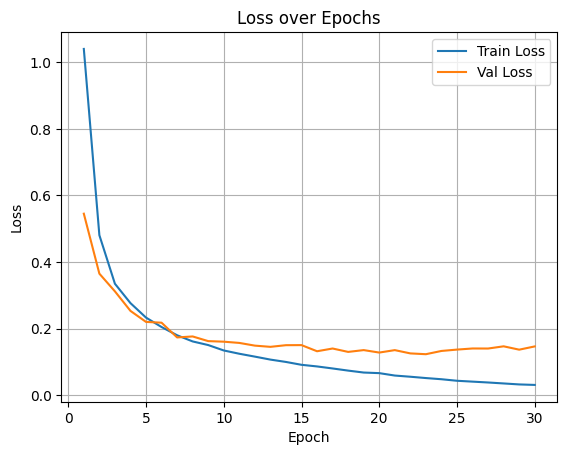

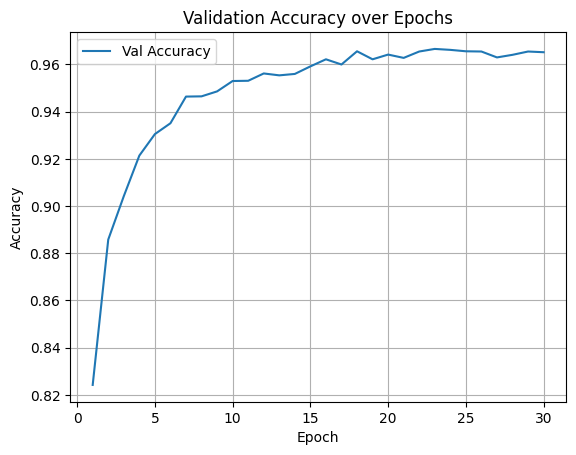

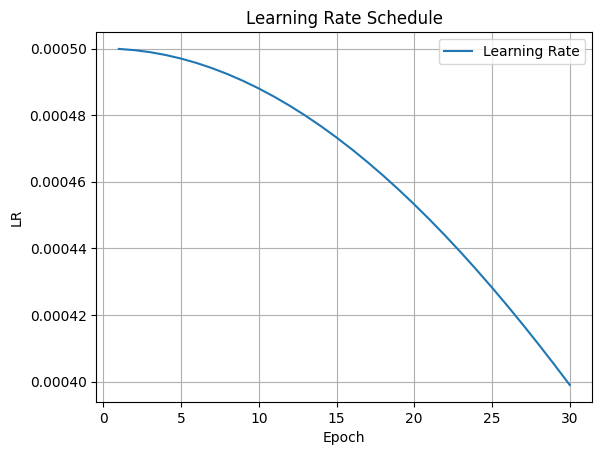

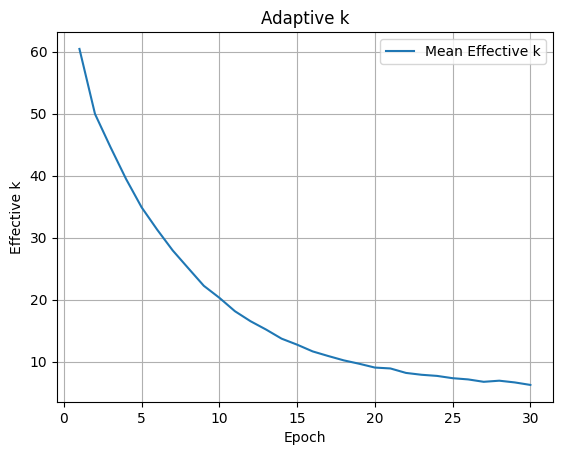

In [ ]:
epochs_range = range(1, epochs+1)
# Removed unexpected indentation from the following lines
plt.figure()
plt.plot(epochs_range, history['train_loss'], label='Train Loss')
plt.plot(epochs_range, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend(); plt.grid()
plt.savefig("./mnist_loss.png")

plt.figure()
plt.plot(epochs_range, history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend(); plt.grid()
plt.savefig("./mnist_acc.png")

plt.figure()
plt.plot(epochs_range, history['lr'], label='Learning Rate')
plt.xlabel('Epoch'); plt.ylabel('LR')
plt.title('Learning Rate Schedule')
plt.legend(); plt.grid()

plt.figure()
plt.plot(epochs_range, k_history, label='Mean Effective k')
plt.xlabel('Epoch'); plt.ylabel('Effective k')
plt.title('Adaptive k')
plt.legend(); plt.grid()
plt.savefig("./mnist_k.png")

plt.show()

CIFAR-10 실험용

In [ ]:
import math
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange, repeat
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# ---------------------------
# Utility Modules
# ---------------------------

def exists(val):
    return val is not None

class GEGLU(nn.Module):
    def forward(self, x):
        x, gates = x.chunk(2, dim=-1)
        return x * F.gelu(gates)

class FeedForward(nn.Module):
    def __init__(self, dim, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult * 2),
            GEGLU(),
            nn.Linear(dim * mult, dim)
        )
    def forward(self, x):
        return self.net(x)

class LinformerAttention(nn.Module):
    def __init__(
        self,
        dim,
        seq_len_q,
        k_max,
        seq_len_kv=None,
        heads=8,
        dim_head=64,
        dropout=0.1
    ):
        super().__init__()
        self.seq_len_q = seq_len_q
        self.seq_len_kv = seq_len_kv if exists(seq_len_kv) else seq_len_q
        self.k_max = k_max
        self.heads = heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5

        inner_dim = heads * dim_head
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_kv = nn.Linear(dim, inner_dim * 2, bias=False)

        # low-rank projection matrices & gating
        self.proj_k = nn.Parameter(torch.randn(self.seq_len_kv, k_max))
        self.proj_v = nn.Parameter(torch.randn(self.seq_len_kv, k_max))
        self.gate_k = nn.Parameter(torch.ones(k_max) * 0.5)
        self.gate_v = nn.Parameter(torch.ones(k_max) * 0.5)
        self.alpha_k = nn.Parameter(torch.tensor(1.0))
        self.alpha_v = nn.Parameter(torch.tensor(1.0))

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x, context=None):
        b, n_q, _ = x.shape
        context = x if context is None else context
        _, n_kv, _ = context.shape

        q = self.to_q(x)
        k, v = self.to_kv(context).chunk(2, dim=-1)

        eff_k = self.proj_k * (torch.sigmoid(self.gate_k) * self.alpha_k)
        eff_v = self.proj_v * (torch.sigmoid(self.gate_v) * self.alpha_v)

        k = torch.einsum('b n d, n k -> b k d', k, eff_k)
        v = torch.einsum('b n d, n k -> b k d', v, eff_v)

        h = self.heads
        q = rearrange(q, 'b n (h d) -> b h n d', h=h)
        k = rearrange(k, 'b k (h d) -> b h k d', h=h)
        v = rearrange(v, 'b k (h d) -> b h k d', h=h)

        attn = (q @ k.transpose(-1, -2)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        out = attn @ v
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

# ---------------------------
# Sinusoidal Positional Encoding
# ---------------------------

class SinusoidalPE(nn.Module):
    def __init__(self, seq_len, dim):
        super().__init__()
        pe = torch.zeros(seq_len, dim)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, dim, 2, dtype=torch.float) * -(math.log(10000.0) / dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # non-trainable

    def forward(self, x):
        # x: (B, seq_len, dim)
        return x + self.pe.unsqueeze(0)

# ---------------------------
# PerceiverIO with Hybrid PE
# ---------------------------

class PerceiverIO(nn.Module):
    def __init__(
        self,
        seq_len: int,
        num_latents: int = 64,
        latent_dim: int = 64,
        depth: int = 2,
        latent_heads: int = 4,
        latent_dim_head: int = 16,
        dropout: float = 0.1,
        k_max: int = 128,
    ):
        super().__init__()
        self.seq_len = seq_len
        self.latent_dim = latent_dim

        # 1) learnable pos emb, but zero-initialized (so it starts neutral)
        self.pos_emb = nn.Parameter(torch.zeros(seq_len, latent_dim))
        # 2) sinusoidal PE
        self.sin_pe = SinusoidalPE(seq_len, latent_dim)

        # global latents
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))
        self.layers = nn.ModuleList()

        for i in range(depth):
            if i == 0:
                attn = LinformerAttention(
                    dim=latent_dim,
                    seq_len_q=num_latents,
                    seq_len_kv=seq_len,
                    k_max=k_max,
                    heads=latent_heads,
                    dim_head=latent_dim_head,
                    dropout=dropout
                )
            else:
                attn = LinformerAttention(
                    dim=latent_dim,
                    seq_len_q=num_latents,
                    k_max=k_max,
                    heads=latent_heads,
                    dim_head=latent_dim_head,
                    dropout=dropout
                )
            ff = FeedForward(latent_dim)
            self.layers.append(nn.ModuleList([attn, ff]))

        self.norm = nn.LayerNorm(latent_dim)

    def forward(self, x, context=None):
        # x: (B, seq_len, latent_dim)
        # apply both PEs:
        x = x + self.pos_emb.unsqueeze(0)     # learnable (starts zero)
        x = self.sin_pe(x)                    # fixed sin-cos

        b = x.size(0)
        latents = repeat(self.latents, 'n d -> b n d', b=b)

        for i, (attn, ff) in enumerate(self.layers):
            if i == 0:
                latents = attn(latents, context=x) + latents
            else:
                latents = attn(latents) + latents
            latents = ff(latents) + latents

        return self.norm(latents)

In [ ]:
# ---------------------------
# Training & Evaluation
# ---------------------------
def train_one_epoch(model, embed, classifier, loader, optimizer, device):
    model.train(); embed.train(); classifier.train()
    total_loss, total = 0, 0
    for batch_idx, (imgs, labels) in enumerate(loader, start=1):
        imgs, labels = imgs.to(device), labels.to(device)
        b = imgs.size(0)

        tokens = imgs.permute(0,2,3,1).reshape(b, -1, 3)
        tokens = embed(tokens)
        latents = model(tokens)
        pooled = latents.mean(dim=1)
        logits = classifier(pooled)

        loss = F.cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item() * b
        total += b
    return total_loss / total

def evaluate(model, embed, classifier, loader, device):
    model.eval(); embed.eval(); classifier.eval()
    total_loss, total_correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            b = imgs.size(0)

            tokens = imgs.permute(0,2,3,1).reshape(b, -1, 3)
            tokens = embed(tokens)
            latents = model(tokens)
            pooled = latents.mean(dim=1)
            logits = classifier(pooled)

            loss = F.cross_entropy(logits, labels)
            preds = logits.argmax(dim=1)

            total_loss += loss.item() * b
            total_correct += (preds == labels).sum().item()
            total += b
    return total_loss / total, total_correct / total


In [ ]:
# ---------------------------
# Main
# ---------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616)),
    ])
    train_ds = datasets.CIFAR10('./data',True,transform=cifar_transform,download=True)
    test_ds  = datasets.CIFAR10('./data',False,transform=cifar_transform,download=True)
    train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4)
    test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=4)

    seq_len, latent_dim, num_classes = 32*32, 64, 10
    model = PerceiverIO(seq_len=seq_len, latent_dim=latent_dim).to(device)
    embed = nn.Linear(3, latent_dim).to(device)
    classifier = nn.Linear(latent_dim, num_classes).to(device)

    optimizer = optim.AdamW(
        list(model.parameters()) + list(embed.parameters()) + list(classifier.parameters()),
        lr=2e-4, weight_decay=1e-2
    )
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-5)

    epochs = 35
    history = {
        'train_loss': [],
        'val_loss':   [],
        'val_acc':    [],
        'lr':         []
    }
    k_history = []

    for epoch in range(1, epochs+1):
        tl = train_one_epoch(model, embed, classifier, train_loader, optimizer, device)
        vl, va = evaluate(model, embed, classifier, test_loader, device)
        scheduler.step()

        # 현재 effective k 계산
        gate_k  = model.layers[0][0].gate_k.detach()
        alpha_k = model.layers[0][0].alpha_k.detach()
        eff_k = (torch.sigmoid(gate_k) * alpha_k).mean().item()
        k_max = model.layers[0][0].proj_k.size(1)  # proj_k: [seq_len_kv, k_max]
        eff_k *= k_max
        # 기록
        history['train_loss'].append(tl)
        history['val_loss'].append(vl)
        history['val_acc'].append(va)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        k_history.append(eff_k)

        print(f"Epoch {epoch:03d} | "
              f"TrainLoss {tl:.4f} | ValLoss {vl:.4f} | ValAcc {va:.4f} | "
              f"LR {optimizer.param_groups[0]['lr']:.1e} | k={eff_k:.2f}")

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch 001 | TrainLoss 2.0324 | ValLoss 1.8755 | ValAcc 0.3167 | LR 2.0e-04 | k=79.42
Epoch 002 | TrainLoss 1.8405 | ValLoss 1.7693 | ValAcc 0.3550 | LR 2.0e-04 | k=78.68
Epoch 003 | TrainLoss 1.7417 | ValLoss 1.6751 | ValAcc 0.3976 | LR 2.0e-04 | k=77.61
Epoch 004 | TrainLoss 1.6622 | ValLoss 1.6046 | ValAcc 0.4253 | LR 2.0e-04 | k=76.60
Epoch 005 | TrainLoss 1.6092 | ValLoss 1.5711 | ValAcc 0.4382 | LR 2.0e-04 | k=75.71
Epoch 006 | TrainLoss 1.5668 | ValLoss 1.5253 | ValAcc 0.4523 | LR 2.0e-04 | k=74.64
Epoch 007 | TrainLoss 1.5267 | ValLoss 1.4927 | ValAcc 0.4678 | LR 2.0e-04 | k=73.99
Epoch 008 | TrainLoss 1.4998 | ValLoss 1.4837 | ValAcc 0.4688 | LR 2.0e-04 | k=73.18
Epoch 009 | TrainLoss 1.4713 | ValLoss 1.4656 | ValAcc 0.4764 | LR 2.0e-04 | k=71.71
Epoch 010 | TrainLoss 1.4472 | ValLoss 1.4555 | ValAcc 0.4779 | LR 2.0e-04 | k=71.37
Epoch 011 | TrainLoss 1.4191 | ValLoss 1.4216 | ValAcc 0.4891 | LR 1.9e-04 | k=70.53
Epoch 012 | TrainLoss 1.4051 | ValLoss 1.4381 | ValAcc 0.4883 | L

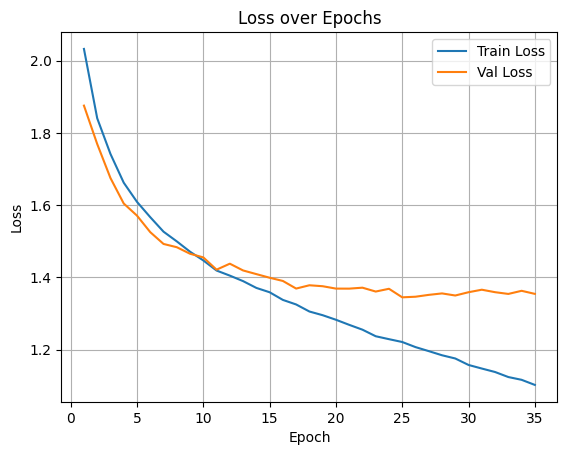

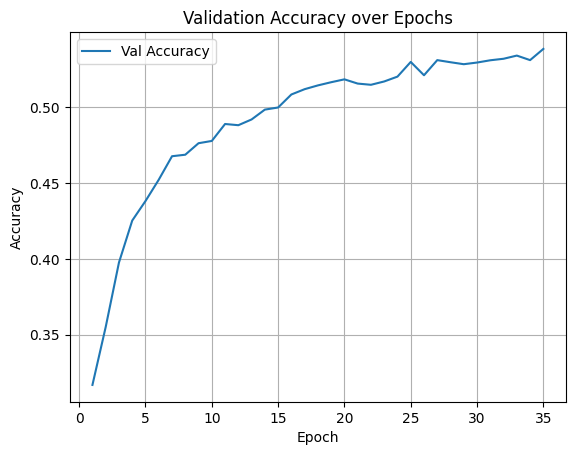

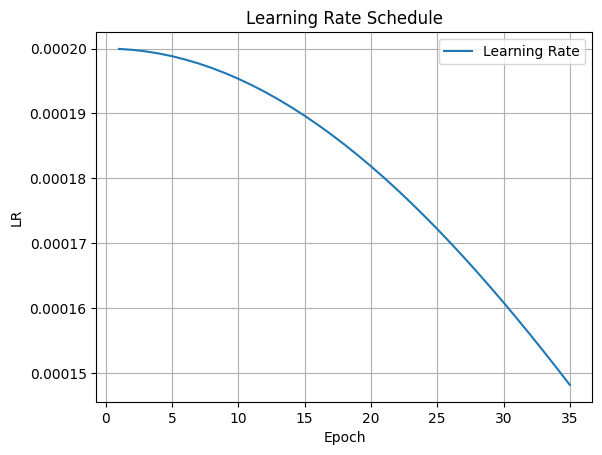

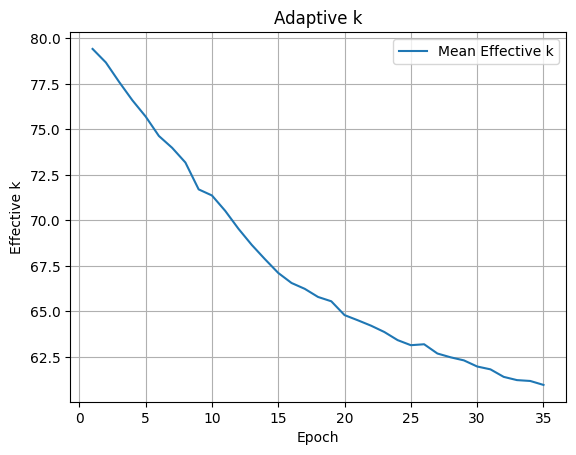

In [ ]:
    # ---------------------------
    # Visualization
    # ---------------------------

    epochs_range = range(1, epochs+1)

    plt.figure()
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'],   label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend(); plt.grid()
    plt.savefig("./cifar_loss.png")

    plt.figure()
    plt.plot(epochs_range, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend(); plt.grid()
    plt.savefig("./cifar_acc.png")

    plt.figure()
    plt.plot(epochs_range, history['lr'], label='Learning Rate')
    plt.xlabel('Epoch'); plt.ylabel('LR')
    plt.title('Learning Rate Schedule')
    plt.legend(); plt.grid()

    plt.figure()
    plt.plot(epochs_range, k_history, label='Mean Effective k')
    plt.xlabel('Epoch'); plt.ylabel('Effective k')
    plt.title('Adaptive k')
    plt.legend(); plt.grid()
    plt.savefig("./cifar_k.png")

    plt.show()